In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import xdas as xd

## Data generation

In [2]:
# Receiver
nch = 101  # number of receivers
fs = 100.0  # sampling rate
nt = 256  # number of samples
L = 1000.0  # length of the cable

# Source
fc = 10.0  # center frequency
xs = 0.0  # x-coordinate
ys = 500.0  # y-coordinate

# Physics
c = 1500.0  # wave speed

In [3]:
# Time vector
t = (np.arange(nt) - nt // 4) / fs

# Receiver coordinates
xr = np.linspace(-L / 2, L / 2, nch)
yr = np.zeros(nch)

# Generate random signal
np.random.seed(42)
signal = np.random.randn(nt, nch)
delay = np.hypot(xr - xs, yr - ys) / c
for idx in range(nch):
    signal[:, idx] += 2.0 * scipy.signal.gausspulse(t - delay[idx], fc=10.0)

In [4]:
# Package into data arrays
signal = xd.DataArray(
    signal,
    {
        "time": ("time", t),
        "distance": ("distance", np.linspace(0, L, nch)),
        "x": ("distance", xr),
        "y": ("distance", yr),
    },
    dims=["time", "distance"],
)
delay = xd.DataArray(
    delay,
    {
        "distance": ("distance", np.linspace(0, L, nch)),
        "x": ("distance", xr),
        "y": ("distance", yr),
    },
    dims=["distance"],
)

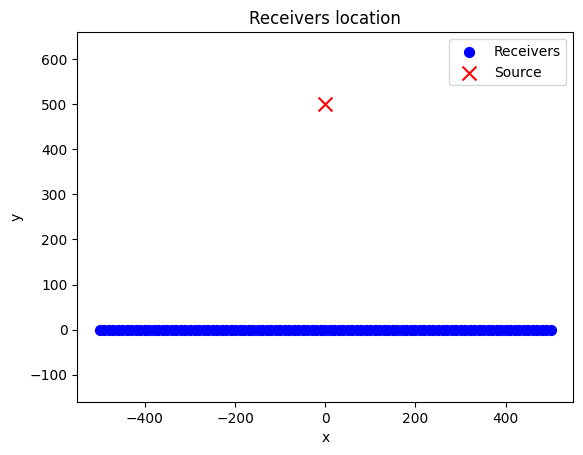

In [5]:
# Plot receivers and source location
plt.scatter(xr, yr, color="blue", marker="o", s=50, label="Receivers")
plt.scatter(xs, ys, color="red", marker="x", s=100, label="Source")
plt.legend()
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Receivers location")
plt.show()

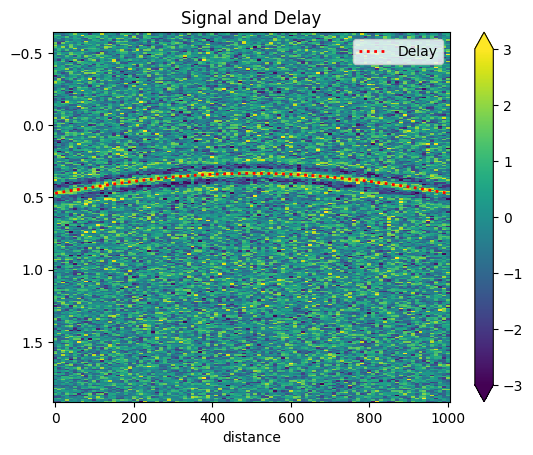

In [6]:
# Plot signal and delay
signal.plot(vmin=-3, vmax=3, yincrease=False)
delay.plot(color="red", linewidth=2, linestyle=":", label="Delay")
plt.title("Signal and Delay")
plt.legend()
plt.show()

## Delay

In [7]:
# Grid points
xg = np.linspace(-500, 500, 101)
xg = xd.DataArray(xg, {"x": xg})

yg = np.linspace(0, 1000, 101)
yg = xd.DataArray(yg, {"y": yg})

# Sensor points

# BUG in DataArray.to_dataarray()
xr = xd.DataArray(signal["x"].values, {"distance": signal["distance"].values})
yr = xd.DataArray(signal["y"].values, {"distance": signal["distance"].values})

# Compute delay from grid to sensors
delay = np.hypot(xr - xg, yr - yg) / c

delay.coords

Coordinates:
  * distance (distance): [   0. ... 1000.]
  * x (x): [-500. ...  500.]
  * y (y): [   0. ... 1000.]

## Beamform

In [8]:
import xbeam as xb
import xdas.fft as xfft


# Compute spectra
X = signal.drop_coords("x", "y")
# X = xp.taper(X, dim="time")  # Optional time tapering to reduce side lobes
# X = xp.taper(X, dim="distance")  # Optional spatial tapering to reduce side lobes
X = xfft.rfft(X, dim={"time": "frequency"})

# Beamforming
B = xb.beamform(X, delay, spectral_dim="frequency", sensor_dim="distance")

# Compute beam power
P = xb.power(B, dim="frequency")

# Compute beamformed signal in time domain (optional)
b = xfft.irfft(B, dim={"frequency": "time"})
p = xb.power(b, dim="time")  # Should be the same as P above

# For impulsive sources, extract beam signal at expected source arrival time (optional)
idx = 32  # expected source arrival time index
s = b.isel(time=idx)

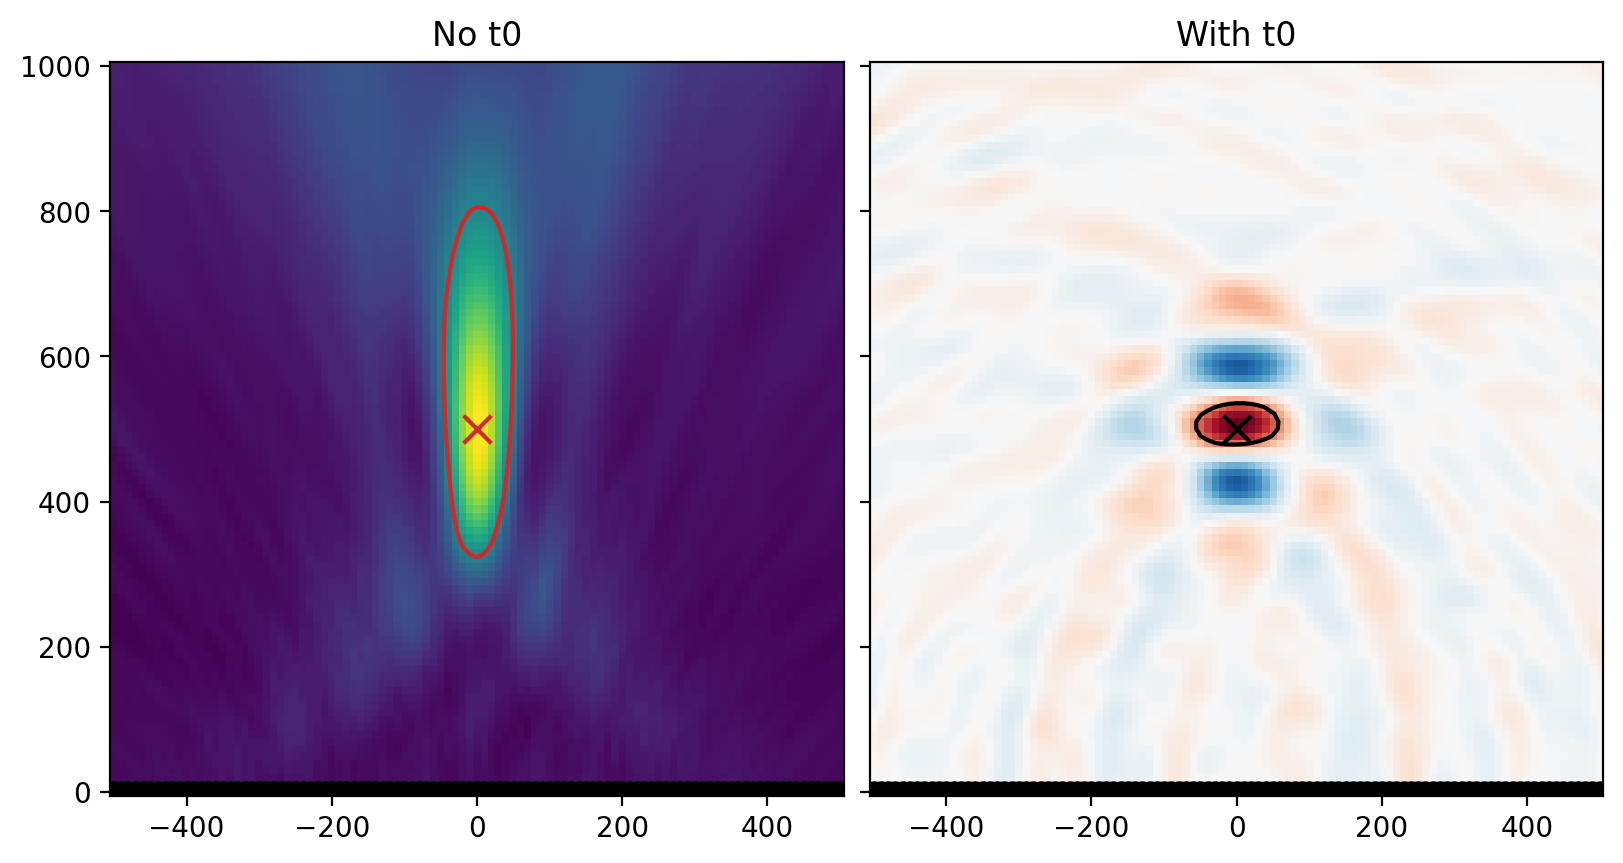

In [9]:
# Plot
fig, axs = plt.subplots(
    1, 2, sharex=True, sharey=True, figsize=(8, 5), layout="constrained", dpi=200
)

ax = axs[0]
P.plot(x="x", y="y", ax=axs[0], add_colorbar=False, add_labels=False)
P.to_xarray().plot.contour(
    x="x",
    y="y",
    levels=[P.max().values * f for f in [0.5]],
    colors=["C3"],
    ax=ax,
    add_labels=False,
)
ax.scatter(xs, ys, color="C3", marker="x", s=100, label="Source")
ax.set_title("No t0")

ax = axs[1]
s.plot(x="x", y="y", ax=ax, add_colorbar=False, add_labels=False)
s.to_xarray().plot.contour(
    ax=ax,
    x="x",
    y="y",
    levels=[s.max().values * f for f in [0.5]],
    colors=["black"],
    add_labels=False,
)
ax.scatter(xs, ys, color="black", marker="x", s=100, label="Source")
ax.set_title("With t0")

for ax in axs:
    ax.set_aspect("equal")
    ax.scatter(xr, yr, color="black", marker="o", s=50, label="Receivers")

## Sliding Beamforming

In [10]:
import xdas.signal as xp

# Compute spectra
x = signal.drop_coords("x", "y")
# x = xp.taper(x, dim="distance")  # Optional spatial tapering to reduce side lobes

X = xp.stft(
    x, window="hann", nperseg=64, noverlap=32, nfft=128, dim={"time": "frequency"}
)

# Beamforming
B = xb.beamform(X, delay, spectral_dim="frequency", sensor_dim="distance")

# Compute beam power
P = xb.power(B, dim="frequency")

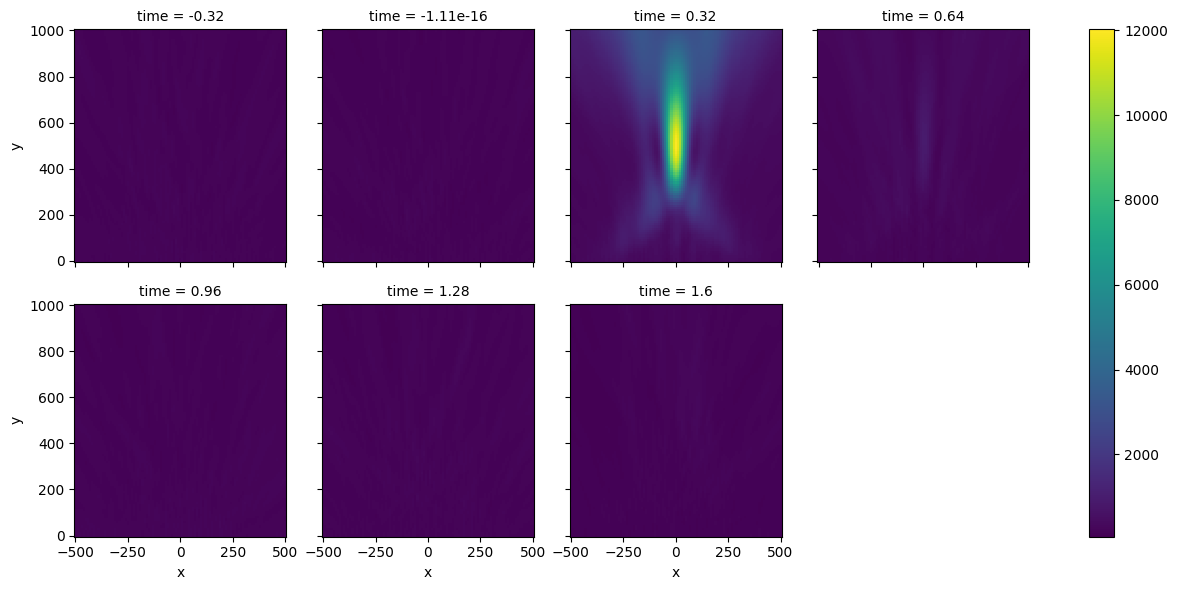

In [11]:
P.plot(x="x", y="y", col="time", col_wrap=4)